# Big Data Lab CHURN Model
 (*made by Ryzhuk Volodymyr*)

## Етапи роботи:
1. **Побудува базової моделі використовуючи LightGBM**
- missing values замінив -1
- розбивка на валідаційну і тестову вибірки
- вийшов на результат 0,88 
2. **Побудова Ансамблю моделей**
- Random Forest
- LogisticRegression
- LGBM 
- тюнінг гіперпараметрів моделей
- результат виявився гірший за base model. Повернувся до 1-го пункту.
3. **Робота із датасетом DPI**
- написана функція для транспонування датасету
- додав датасет в df_train_fe
- тренування на LGBM
- підбір гіперпараметрів
- результати виявились гіршими від base model. Повертаюсь до пункту 1.
4. **Feature importance**
- виділив з базової моделі найбільш важливі features.
- модель без заповнень місінгів дає кращі результати
- будую матрицю кореляцій по Спірмену, щоб виявити висококорельовані ознаки.
- перенавчаю модель на новому наборі фічей
- результат ROC-AUC = 0.87. Результат не влаштовує.
5. **Стратифікація вибірки**
- заново тренування моделі на базових фічах
- роблю знов пункт 4 (feature importance із порогом кореляції 0,95)
- відбираю 312 фічей
- треную модель
- вийшов на результат ROC-AUC 0.896 (LGBMClassifier_01072023_15_56.pickle)
6. **Тренування моделі при поступовому додаванні фічей** 
- *ідея полягала в тому, щоб вибрати менше фічей, але з кращим результатом*
- виділи найбільш важливі фічі
- залишив ті, які корельовані менше 95%
- тренування моделі з поступовим додаванням фічей.
- результат ROC-AUC 0.82. Повертаюсь до пукту 5
7. **Пошук нових фічей в датасеті DPI**
- повернувся до кроку 3
- ще раз потестив модель
- вибрав feature importance >0
- побудував матрицю кореляцій по Спірмену
- видалив фічі, в яких кореляція більше 0,95
- трейнив модель. Результат ROC-AUC = 0,895. Зберіг як ще один варіант (LGBMClassifier_07072023_19_46.pickle) на 675 фічей
- зробив тюнінг гіперпараметрів.
- результат на train 0.92
8. **Пошук нових фічей в датасеті NUM**
- трансформував датасет b_num, виділив популярні номери, на які були дзвінки
- додав в датасет із трансформованими DPI даними. 
- навчив модель
- виділив найважливіші фічі
- видалив висококорельовані
- знов навчив модель


## Import Libraries
![](flow_1.jpg)



In [19]:
# основні функції збережені в файлі my_func.py
# save_model()
# load_pickle()
# reduce_mem_usage()
# categorical_col_info()

 

In [1]:
# імпортую бібліотеки
import pandas as pd
import pickle
import my_func # посилання на окремий файл, де зібрані вже відомі вам функції для роботи
import lightgbm as lgb
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime, timedelta
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import shap
from hyperopt import hp, fmin, tpe
sns.set()


## Load Data
![Alt text](Flow_2.jpg)

In [2]:
# посилання на вже розпаковані і зменшені в обємі файли
fe_name_tr = 'churn_train_model_fe.pickle'
b_num_name_tr ='churn_train_model_b_num.pickle'
dpi_name_tr ='churn_train_model_dpi.pickle'

fe_name_te = 'churn_test_model_fe.pickle'
b_num_name_te ='churn_test_model_b_num.pickle'
dpi_name_te ='churn_test_model_dpi.pickle'

# посилання на робочу папку з pickle архівами
file_path = r'D:\BDL-Final\data-from-BDL' + '\\'

# показати максимальну кількість колонок в редакторі
pd.set_option('display.max_columns', None)

# Завантаження датафреймів
df_train_fe = pd.read_pickle(file_path+fe_name_tr)
df_train_dpi = pd.read_pickle(file_path+dpi_name_tr)
df_train_b_num = pd.read_pickle(file_path+b_num_name_tr)

df_test_fe = pd.read_pickle(file_path+fe_name_te)
df_test_dpi = pd.read_pickle(file_path+dpi_name_te)
df_test_b_num = pd.read_pickle(file_path+b_num_name_te)



## Explore & Feature engineering
![Alt text](flow_3.jpg)

In [3]:
# Висновки: 
# датафрейм без категоріальних фічей. 
# вибірка незбалансована, цільова зміна представлена в 6% значень
# є пропущені значення

In [4]:
import plotly.graph_objects as go

target_counts = df_train_fe['target'].value_counts()

fig = go.Figure(data=[
    go.Bar(x=target_counts.index, y=target_counts.values, text=target_counts.values, textposition='auto')
])

fig.update_layout(
    title='Distribution of target value',
    xaxis_title='target',
    yaxis_title='Frequency',
    width=600  # 
)

fig.update_traces(texttemplate='%{text}', textfont_size=12)

fig.show()





### Transforming DPI dataset


In [ ]:
# !!! код виконується в середньому 12 годин!!!
#основна ідея - транспонувати таблицю DPI, де кількість стовпчиків буде = кількості додатків

In [ ]:



# Збираємо унікальні значення колонок в обох датафреймах, щоб потім можна було test прогнати
unique_abon_ids = df_train_dpi['abon_id'].unique()
unique_values_train = df_train_dpi['Application'].unique()
unique_values_test = df_test_dpi['Application'].unique()
unique_applications = np.unique(np.concatenate((unique_values_train, unique_values_test)))

# передаємо унікальні колонки датасету. Якщо буду запускати test вибірку - то треба поміняти
df_t = pd.DataFrame({'abon_id': unique_abon_ids})

# ітерація по унікальних id
filtered_dfs = {}
for app in unique_applications:
    filtered_dfs[app] = df_train_dpi[df_train_dpi['Application'] == app]

# ініціалізація колонок
column_values = {}
for app in unique_applications:
    col_names = [f"{app}_SUM_of_Duration_sec", f"{app}_SUM_of_Volume_kb", f"{app}_SUM_of_Count_events", f"{app}_MAX_of_day_cnt"]
    column_values[col_names[0]] = []
    column_values[col_names[1]] = []
    column_values[col_names[2]] = []
    column_values[col_names[3]] = []

# тут будемо виводити результат кожні 3 хвилини
progress_interval = 3 * 60  # 3 minutes

# ітерація по рядкам
total_rows = len(df_t)
start_time = time.time()
last_progress_time = start_time
for row_index, row in df_t.iterrows():
    abon_id = row['abon_id']
    
    # ітерація по applications
    for app_index, app in enumerate(unique_applications):
        col_names = [f"{app}_SUM_of_Duration_sec", f"{app}_SUM_of_Volume_kb", f"{app}_SUM_of_Count_events", f"{app}_MAX_of_day_cnt"]
        filtered_df = filtered_dfs[app]
        
        # фільтруємо
        values = filtered_df.loc[filtered_df['abon_id'] == abon_id, ['SUM_of_Duration_sec', 'SUM_of_Volume_kb', 'SUM_of_Count_events', 'MAX_of_day_cnt']].values
        
        if len(values) > 0:
            column_values[col_names[0]].append(values[0][0])
            column_values[col_names[1]].append(values[0][1])
            column_values[col_names[2]].append(values[0][2])
            column_values[col_names[3]].append(values[0][3])
        else:
            column_values[col_names[0]].append(None)
            column_values[col_names[1]].append(None)
            column_values[col_names[2]].append(None)
            column_values[col_names[3]].append(None)
    
    # публікуй прогрес 3 хвилини
    current_time = time.time()
    elapsed_time = current_time - last_progress_time
    if elapsed_time >= progress_interval:
        progress = (row_index + 1) / total_rows * 100
        print(f"Progress: {progress:.2f}%")
        last_progress_time = current_time

# додавання значень
for col_name, values in column_values.items():
    df_t[col_name] = values


#print(df_t)


In [6]:

df_t = pd.read_pickle('df_train_dpi_t_v2.pickle')

In [7]:
df_t

abon_id  14.0_SUM_of_Duration_sec  14.0_SUM_of_Volume_kb  \
0         1545235.0                       NaN                    NaN   
1         1549591.0                       NaN                    NaN   
2         1558772.0                       NaN                    NaN   
3         1558921.0                       NaN                    NaN   
4         1560464.0                       NaN                    NaN   
...             ...                       ...                    ...   
122083  130753784.0                       NaN                    NaN   
122084  130753819.0                       NaN                    NaN   
122085  130754333.0                       NaN                    NaN   
122086  130754629.0                       NaN                    NaN   
122087  130754935.0                       NaN                    NaN   

        14.0_SUM_of_Count_events  14.0_MAX_of_day_cnt  \
0                            NaN                  NaN   
1                            NaN                  NaN   
2                            NaN                  NaN   
3                            NaN                  NaN   
4                            NaN                  NaN   
...                          ...                  ...   
122083                       NaN                  NaN   
122084                       NaN                  NaN   
122085                       NaN                  NaN   
122086                       NaN                  NaN   
122087                       NaN                  NaN   

       22.0_SUM_of_Duration_sec 22.0_SUM_of_Volume_kb  \
0                          None                  None   
1                          None                  None   
2                          None                  None   
3                          None                  None   
4                          None                  None   
...                         ...                   ...   
122083                     None                  None   
122084                     None                  None   
122085                     None                  None   
122086                     None                  None   
122087                     None                  None   

       22.0_SUM_of_Count_events 22.0_MAX_of_day_cnt  23.0_SUM_of_Duration_sec  \
0                          None                None                       NaN   
1                          None                None                       NaN   
2                          None                None                       NaN   
3                          None                None                       NaN   
4                          None                None                       NaN   
...                         ...                 ...                       ...   
122083                     None                None                 31.530630   
122084                     None                None                       NaN   
122085                     None                None                       NaN   
122086                     None                None                       NaN   
122087                     None                None                 28.912242   

        23.0_SUM_of_Volume_kb  23.0_SUM_of_Count_events  23.0_MAX_of_day_cnt  \
0                         NaN                       NaN                  NaN   
1                         NaN                       NaN                  NaN   
2                         NaN                       NaN                  NaN   
3                         NaN                       NaN                  NaN   
4                         NaN                       NaN                  NaN   
...                       ...                       ...                  ...   
122083               9.865913                  5.827796                  1.0   
122084                    NaN                       NaN                  NaN   
122085                    NaN                       NaN                  NaN   
1220

In [ ]:
# після того, як сформований новий датасет, додаю його до базового датасету

In [ ]:
# load transformed DPI dataset
df_train_dpi_t_v2 = pd.read_pickle('df_train_dpi_t_v2.pickle')
df_train_fe = pd.read_pickle(file_path+fe_name_tr)


In [ ]:
# поєдную два датасети по 'abon_id' 
df_combined = pd.merge(df_train_fe, df_train_dpi_t_v2, on='abon_id', how='left')

#len(df_combined['abon_id'])
# зменшую память
#df_combined = my_func.reduce_mem_usage(df_combined)

In [ ]:
# зберігаю в pickle файл.
#df_combined.to_pickle('df_train_fe_dpi.pickle')

### Transform Num dataset

In [ ]:
# для роботи із датасетом b_num використав наступний підхід
# 1. звертаю увагу на вихідні дзвінки
# відсортував по датасет по популярності дзвінків
# вияснив, які служби/організації стоять за номерами
# трансформував дані через зведені таблиці

In [33]:
bnum_list = ["b'111'", "b'3700'", "b'380800210800'", "b'1545'", "b'112'", "b'102'", "b'103'", "b'380505022250'", "b'380502907290'"]
df_test_b_num['bnum'] = df_test_b_num['bnum'].astype(str)

# Filter the DataFrame based on the 'bnum' column
df_filtered = df_test_b_num[df_test_b_num['bnum'].str.contains('|'.join(bnum_list))]



# # Pivot the filtered DataFrame
pivot_table = df_filtered.pivot_table(values='call_cnt_out', index='abon_id', columns='bnum', aggfunc=np.sum)

# Define the old and new column names
old_column_names = ["b'111'", "b'3700'", "b'380800210800'", "b'1545'", "b'112'", "b'102'", "b'103'", "b'380505022250'", "b'380502907290'"]
new_column_names = ["vodafone", "PryvatBank", "OshchadBank", "GovUa", "ExtDopomoga", "Police", "Emergancy", "VoliaCable", "PUMB"]

# Create a dictionary to map the old column names to the new column names
column_name_mapping = dict(zip(old_column_names, new_column_names))

# Rename the columns in the DataFrame
pivot_table = pivot_table.rename(columns=column_name_mapping)


pivot_table

bnum,Police,Emergancy,vodafone,ExtDopomoga,GovUa,PryvatBank,PUMB,VoliaCable,OshchadBank
abon_id,,,,,,,,,
1538501.0,NaN,NaN,NaN,NaN,NaN,2.206949,NaN,NaN,NaN
1545752.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.480453
1546159.0,NaN,NaN,NaN,NaN,NaN,NaN,2.921812,NaN,NaN
1563746.0,NaN,NaN,1.480453,NaN,NaN,NaN,NaN,NaN,NaN
1577252.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.480453,NaN
...,...,...,...,...,...,...,...,...,...
130737889.0,NaN,NaN,3.590290,NaN,NaN,NaN,NaN,NaN,NaN
130737911.0,NaN,NaN,1.480453,NaN,NaN,NaN,NaN,NaN,NaN
130747710.0,NaN,NaN,1.480453,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# поєднуємо два датафрейми 'abon_id'
df_test_fe_dpi = pd.read_pickle('df_test_fe_dpi_v2.pickle')
df_test_fe_dpi_num = pd.merge(df_test_fe_dpi, pivot_table, on='abon_id', how='left')

In [36]:
# df_test_fe_dpi_num['PryvatBank'].sum()

20468.968627590086

In [37]:
df_test_fe_dpi_num.to_pickle('df_test_fe_dpi_num.pickle')

### Working with missing values

In [ ]:
# перевірка на missing значення
ms_val = my_func.count_missing_values(df_train_fe[selected_features_293])
ms_val

In [ ]:
X = df_train_fe[selected_features_293]
# Get feature importances
# Get feature importances
importances = model_test.feature_importances_
feature_names = X.columns

# Create a DataFrame with feature names and importances
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})


# Sort the DataFrame by importance in descending order
df_importances = df_importances.sort_values(by='Importance', ascending=False)




In [ ]:
# Merge the two dataframes on the 'Feature' and 'Column' columns
df_merged = ms_val.merge(df_importances, left_on='Column', right_on='Feature', how='left')

# Drop the 'Feature' column as it's redundant
df_merged = df_merged.drop('Feature', axis=1)

# Fill the missing importances with 0
df_merged['Importance'] = df_merged['Importance'].fillna(0)
# Sort the dataframe by the 'Importance' column in descending order
df_sorted = df_merged.sort_values(by='Importance', ascending=False)

# Print the sorted dataframe
df_sorted


In [ ]:
df_sorted.to_excel('missing_important_fea.xlsx')

## Select Model
![Alt text](flow_4.jpg)

In [ ]:
## тут вставити порівняння моделей

## Train Model

### LGBM Train model
![Alt text](flow_5.jpg)

In [ ]:
##
## Тут модель для тренування Train dataframe
##

df_input = pd.read_pickle('df_train_fe_dpi_num.pickle')

# Prepare your data (X and y)
X = df_input.drop(['target', 'abon_id'], axis=1)
y = df_input['target']

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777)

# Define the LGBMClassifier model
clf = lgb.LGBMClassifier(is_unbalance=True)

# Define the number of folds for cross-validation
n_splits = 5

# Initialize an empty list to store the test AUC scores for each fold
test_scores = []

# Perform K-fold cross-validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
for train_index, test_index in kf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the model on the current fold
    clf.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set of the current fold
    y_val_pred = clf.predict(X_test_fold)
    
    # Calculate and store the AUC score for the current fold
    test_scores.append(roc_auc_score(y_test_fold, y_val_pred))

# Print the test AUC scores for each fold
for i, score in enumerate(test_scores):
    print(f"Fold {i+1} Test AUC = {score:.3f}")

# Calculate and print the average test AUC across all folds
print(f"Average Test AUC = {np.mean(test_scores):.3f}")


In [18]:
#saving model
#my_func.save_model(clf, X.columns.tolist()) 


Save LGBMClassifier_08072023_16_20.pickle


In [ ]:
y_train =df_train_fe['target']
y_test = df_test_fe['target']
fea_clf = clf.feature_names_in_
pred_clf_test = model_test.predict_proba(X_test[fea_clf])[:,1]

pred_clf = clf.predict_proba(X_train[fea_clf])[:,1]

9580.0

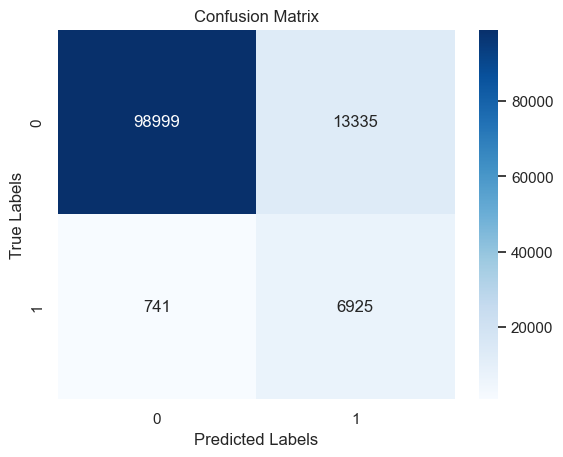

In [19]:
import seaborn as sns

# Predict test values using the LGBM model
y_pred = clf.predict(X_train)

# Calculate the confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

## Feature Selection
![Alt text](flow_6.jpg)

In [22]:

#"LGBMClassifier_07072023_18_17.pickle"

def my_feature_importance(pickle_file):
    """
    функція отримує на вхід посилання на модель
    на виході отримаємо датафрейм із фічами та їх importance
    """    

    # завантаження моделі
    model_train, features = my_func.load_pickle(pickle_file)
    importances = model_train.feature_importances_
    feature_names = features

    # Створюємо датафрейм із вибраними з моделі фічами
    df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

    # сортуємо фічі
    df_importances = df_importances.sort_values(by='Importance', ascending=False)
    return df_importances

In [40]:


def my_feature_cor (df_importances: pd.DataFrame, df_train: pd.DataFrame,treshhold_cor = 0.95 ) -> pd.DataFrame:
    """
    функція отримує на вхід датафрейм із важливістю фічей
    відбираються ті, що більше 0 і далі знаходиться матриця кореляції по Спірмену
    df_train: датасет в якому по відібраних фічах з датафрейму df_importance будемо рахувати кореляції
    """

    # відбираємо тільки ті фічі, важливість яких більша 0
    
    df_imp = df_importances[df_importances['Importance']>0]
    # Get the list of selected features
    selected_features = df_imp['Feature'].tolist()

    # Calculate the Spearman correlation for the selected features
    correlation_matrix = df_train[selected_features].corr(method='spearman')

    #correlation_matrix
    # збереження матриці
    #correlation_matrix.to_pickle('cor_matrix_train_fe_dpi.pickle')

    # завантаження матриці
    #correlation_matrix= pd.read_pickle('cor_matrix_base_m.pickle')


    # створюємо маску пошуку
    
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

    # Приміняємо маску до матриці кореляцій
    corr_matrix_masked = correlation_matrix.where(mask)

    # отримуємо пари де  threshold згідно наших умов
    high_corr_pairs = [(column, row) for column in corr_matrix_masked.columns for row in corr_matrix_masked.index if abs(corr_matrix_masked[column][row]) > treshhold_cor]

    # викидаємо висококорельовані активи
    to_drop = list(set([feature for pair in high_corr_pairs for feature in pair]))

    # Get the selected features by removing the features to drop from the list of all features
    selected_features_result = [feature for feature in selected_features if feature not in to_drop]
    return selected_features_result

    

In [26]:
mod_name = 'LGBMClassifier_08072023_16_20.pickle'
resu = my_feature_importance(mod_name)

In [27]:
resu.to_excel('feature_imp_dpi_num.xlsx')

In [41]:
# читаємо датасет із pickle файлу
df_for_fea_sel = pd.read_pickle('df_train_fe_dpi_num.pickle')
# код довго виконується
# рахуємо матрицю кореляції та залишаємо фічі, менші порогового значення
selected_fea = my_feature_cor(my_feature_importance(mod_name),df_for_fea_sel,treshhold_cor=0.95)

In [46]:
#selected_fea
with open('my_list_selected_fea_dpi_num.pkl', 'wb') as f:
     pickle.dump(selected_fea, f)

## Evaluate/Tune Model
![Alt text](flow_7.jpg)

### Train model with selected features

In [ ]:
#df_dpi = pd.read_pickle('df_train_dpi_t_v2.pickle')
#df_train_fe_dpi['abon_id'] = df_train_fe_dpi['abon_id'].astype(int)
#df_train_fe_dpi = my_func.reduce_mem_usage(df_train_fe_dpi)
#df_dpi = pd.read_pickle('df_train_dpi_t_v2.pickle')

In [5]:
# Завантажуємо датасет
#df_train_fe = pd.read_pickle(file_path+fe_name_tr)
# Prepare your data (X and y)
df_train_fe_dpi_num = pd.read_pickle('df_train_fe_dpi_num.pickle')

# Load the list from the pickle file
with open('my_list_selected_fea_dpi_num.pkl', 'rb') as f:
    selected_fea = pickle.load(f)

X = df_train_fe_dpi_num.drop(['target', 'abon_id'], axis=1)
X= X[selected_fea] #відібрані фічі з останнього повного датафрейму
y = df_train_fe_dpi_num['target']



# Fill missing values with -1
#X.fillna(-1, inplace=True)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)


In [7]:
#X.shape
# X['abon_id']

In [8]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np


# Prepare your data (X and y)
#X = df_train_fe_dpi.drop(['target', 'abon_id'], axis=1)

# train on selected features
#X= X[selected_features_95]
#X= df_train_fe_dpi[selected_features_fe_dpi]

#y = df_train_fe_dpi['target']

# Split the data into train and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777)

# Define the LGBMClassifier model
clf = lgb.LGBMClassifier(is_unbalance=True)

# Define the number of folds for cross-validation
n_splits = 5

# Initialize an empty list to store the test AUC scores for each fold
test_scores = []

# Perform K-fold cross-validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
for train_index, test_index in kf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the model on the current fold
    clf.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set of the current fold
    y_val_pred = clf.predict(X_test_fold)
    
    # Calculate and store the AUC score for the current fold
    test_scores.append(roc_auc_score(y_test_fold, y_val_pred))

# Print the test AUC scores for each fold
for i, score in enumerate(test_scores):
    print(f"Fold {i+1} Test AUC = {score:.3f}")

# Calculate and print the average test AUC across all folds
print(f"Average Test AUC = {np.mean(test_scores):.3f}")


Fold 1 Test AUC = 0.828
Fold 2 Test AUC = 0.816
Fold 3 Test AUC = 0.820
Fold 4 Test AUC = 0.823
Fold 5 Test AUC = 0.823
Average Test AUC = 0.822


In [51]:
#saving model
my_func.save_model(clf, X.columns.tolist()) 

Save LGBMClassifier_08072023_18_03.pickle


### Train with step-by-step feature adding

In [ ]:
# спробував потестити підхід із поступовим додаванням фічей
# переслідував мету проаналізувати, яку кількість фічей достатньо, щоб вийти на цільовий показник.
# відчутного результату не добився. Повернувся до попередніх моделей

In [ ]:
# Define the LGBMClassifier model
clf = lgb.LGBMClassifier(is_unbalance=True)

# Define the number of folds for cross-validation
n_splits = 5

# Initialize an empty list to store the test AUC scores for each fold
test_scores = []

# Perform K-fold cross-validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)

# Loop over the number of features to use for training
for num_features in range(2, len(selected_features_95) + 1):
    
    # Select the subset of features
    X_train_subset = X_train[selected_features_95[:num_features]]
    
    # Reset the test scores for each number of features
    test_scores = []
    
    for train_index, test_index in kf.split(X_train_subset, y_train):
        X_train_fold, X_test_fold = X_train_subset.iloc[train_index], X_train_subset.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Train the model on the current fold
        clf.fit(X_train_fold, y_train_fold)
        
        # Make predictions on the validation set of the current fold
        y_val_pred = clf.predict(X_test_fold)
        
        # Calculate and store the AUC score for the current fold
        test_scores.append(roc_auc_score(y_test_fold, y_val_pred))
    
    # Print the test AUC scores for each fold
    for i, score in enumerate(test_scores):
        print(f"Number of features: {num_features}, Fold {i+1} Test AUC = {score:.3f}")

    # Calculate and print the average test AUC across all folds
    print(f"Average Test AUC for {num_features} features = {np.mean(test_scores):.3f}")



### Tuning hyperparams

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def my_trainer_lgb(model, X_train, y_train):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
    callback2 = lgb.early_stopping(stopping_rounds=50, first_metric_only=False, verbose=True)

    list_tr_acc = []
    list_val_acc = []
    n = 0
    for train_index, val_index in skf.split(X_train, y_train):  # Note the addition of y_train here
        n += 1
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_names=['Train', 'Val'], early_stopping_rounds=20, eval_metric='binary_error', callbacks=[callback2])
        
        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)
        
        list_tr_acc.append(accuracy_score(y_tr, y_tr_pred))
        list_val_acc.append(accuracy_score(y_val, y_val_pred))

    print('Total Accuracy (train) =', np.mean(np.array(list_tr_acc)))
    print('Total Accuracy (val) =', np.mean(np.array(list_val_acc)))
    return np.mean(np.array(list_val_acc)) - (np.mean(np.array(list_tr_acc)) - np.mean(np.array(list_val_acc)))



space = {
    'learning_rate': hp.choice('learning_rate', np.arange(0.001, 0.1, 0.001)),
    'max_depth': hp.choice("max_depth", np.arange(2, 7, 1)),
    'num_leaves': hp.choice('num_leaves', np.arange(10, 128, 10, dtype=int))
}

def objective(params):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'num_boost_round': 1000,
        'is_unbalance': True
    }
    clf = lgb.LGBMClassifier(
        n_jobs=-1,
        **param,
        **params
    )  
    score = my_trainer_lgb(clf, X_train, y_train)
    print("AUC {:.3f} params {}".format(score, params))
    return -score

best = fmin(fn=objective, 
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            return_argmin=False)

best.update({
    'objective': 'binary',
    'num_boost_round': 1000,
    'metric': 'auc',
    'is_unbalance': True
})

clf = lgb.LGBMClassifier(**best)

def model_fit(model, X_tr, y_tr, X_val, y_val):
    callback2 = lgb.log_evaluation(period=10)
    model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_names=['Train', 'Val'], early_stopping_rounds=10, eval_metric='binary_error', callbacks=[callback2]) 
    iterr = model.best_iteration_
    y_tr_pred = model.predict(X_tr, num_iteration=iterr)
    y_val_pred = model.predict(X_val, num_iteration=iterr)
    print('Accuracy (train) =', accuracy_score(y_tr, y_tr_pred))
    print('Accuracy (val) =', accuracy_score(y_val, y_val_pred))
    return model

clf = model_fit(clf, X_train, y_train, X_val, y_val)


In [ ]:
# Calculate and print out the binary classification metrics

best_iter = clf.best_iteration_

# Predict the training set
y_train_pred = clf.predict(X_train, num_iteration=best_iter)

# Predict the validation set
y_val_pred = clf.predict(X_val, num_iteration=best_iter)

# Call the function
my_func.binary_classification_metrics(y_train, y_train_pred, y_val, y_val_pred, report=True)


In [ ]:
import seaborn as sns

# Predict test values using the LGBM model
y_pred = clf.predict(X_train)

# Calculate the confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


## Make prediction
![Alt text](flow_8.jpg)

In [ ]:
# тестуємо модель на даних, що ще не бачила модель

Test AUC = 0.895
Metrics         Train      Test       Δ         
roc_auc         0.8182    
accuracy        0.8648    
precision       0.2848    
recall          0.7649    
f1_score        0.415     


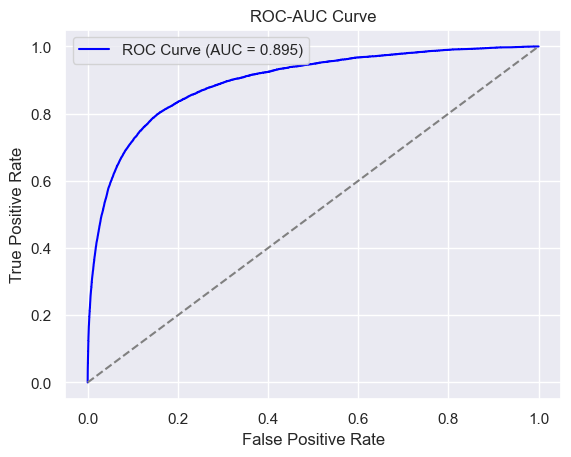

In [9]:

import lightgbm as lgb
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Define the file name of the pickle file
# pickle_file = "LGBMClassifier_01072023_17_07.pickle" 
#pickle_file = "LGBMClassifier_24062023_15_30.pickle"
#pickle_file = "LGBMClassifier_01072023_15_56.pickle"
#pickle_file = "LGBMClassifier_01072023_14_50.pickle"
#pickle_file = "LGBMClassifier_08072023_16_20.pickle" 
#pickle_file = "LGBMClassifier_08072023_18_03.pickle" 
pickle_file = "LGBMClassifier_07072023_19_46.pickle"


# Load the model
model_test, features = my_func.load_pickle(pickle_file)

# Prepare the test data (X_test)
#df_for_test = df_test_fe
df_for_test = pd.read_pickle('df_test_fe_dpi_num.pickle')




y_test = df_for_test['target']
X_test = df_for_test.drop(['target', 'abon_id'], axis=1)
X_test = df_for_test[features]
#X_test.fillna(-1, inplace=True)

# Make predictions on the test data
y_pred = model_test.predict(X_test)

# Calculate the probabilities of the positive class
y_pred_proba = model_test.predict_proba(X_test)[:, 1]

# Calculate the ROC-AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC = {auc:.3f}")


# Calculate and print out the binary classification metrics
my_func.binary_classification_metrics(y_true_tr=y_test, y_pred_tr=y_pred, report=False)


# Plot the ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='blue', label="ROC Curve (AUC = {:.3f})".format(auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()


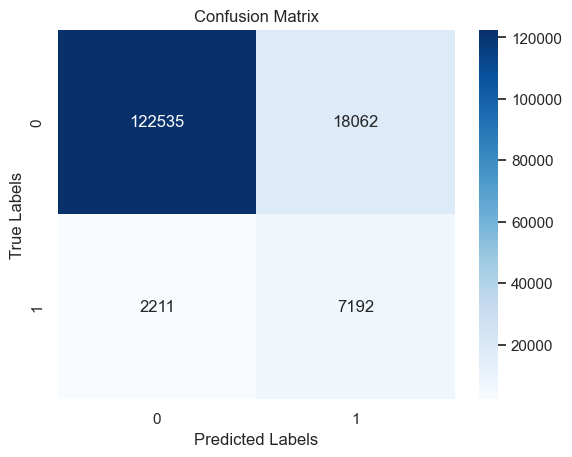

In [10]:
import seaborn as sns

# Predict test values using the LGBM model
y_pred = model_test.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()



In [16]:
# Load the list from the pickle file
with open('my_list_selected_fea_dpi_num.pkl', 'rb') as f:
    selected_fea = pickle.load(f)


In [14]:

# df_train_fe_dpi_num = pd.read_pickle('df_train_fe_dpi_num.pickle')
# pickle_file = "LGBMClassifier_07072023_19_46.pickle"
# model_train, features = my_func.load_pickle(pickle_file)

# y_train = df_train_fe_dpi_num['target']
# # Predict the probabilities for the training set
fea_clf =clf.features
y_train_pred = clf.predict_proba(X_train[fea_clf])[:,1]

# Predict the probabilities for the test set
y_test_pred = model_test.predict_proba(X_test)[:, 1]

# Plot the ROC-AUC curve
my_func.plot_roc_auc_train_test(y_train, y_train_pred, y_test, y_test_pred, "ROC-AUC Curve for LGBM Model")


AttributeError: 'LGBMClassifier' object has no attribute 'features'

In [25]:
len(features)

293

## Interpret/Analyze model
![Alt text](flow_9.png)

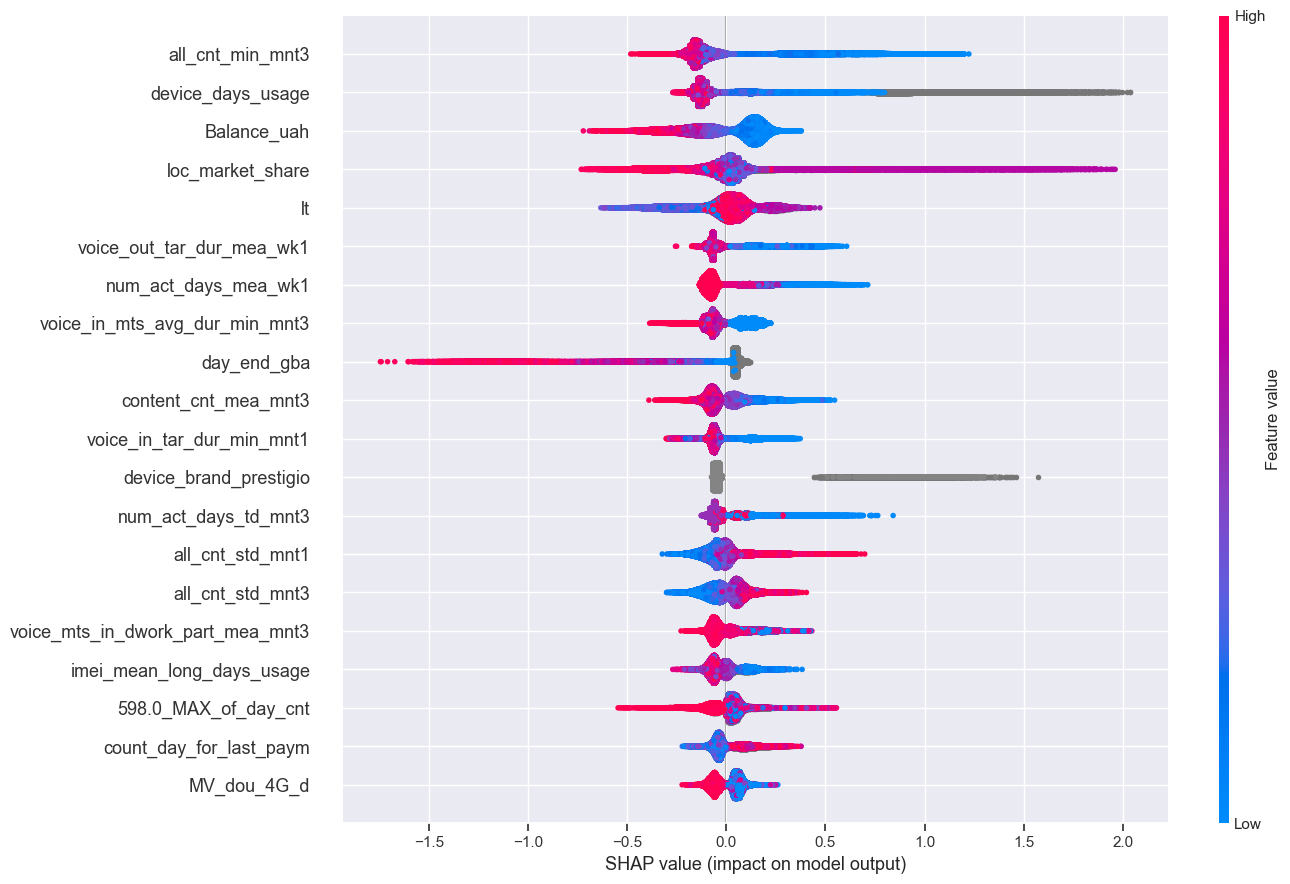

In [54]:
import shap


fea_lgb = model_test.feature_name_
explainer = shap.TreeExplainer(model_test)
shap_values = explainer.shap_values(X_test[fea_lgb])
pd.DataFrame(shap_values[1])
 
shap.summary_plot(shap_values[1], X_test[fea_lgb], plot_size=(14,9)) 



In [36]:
# Calculate mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values[1]).mean(axis=0)

# Create a DataFrame for SHAP importance
shap_importance_df = pd.DataFrame(shap_importance, columns=['SHAP_importance'], index=X_test[fea_lgb].columns)

# Save the DataFrame to a CSV file
shap_importance_df

,SHAP_importance
Ama_rchrgmnt_sum_max_mnt1,0.000000
content_clc_mea_mnt1,0.011296
content_cnt_max_mnt1,0.004672
voice_out_short_part_max_mnt1,0.000983
voice_mts_in_nrest_part_std_mnt1,0.003520
...,...
MV_Migr_To,0.000000
MV_SERV_RLH,0.000000
MV_DOU_PPM_VF,0.010362
MV_DOU_Neg_Bal,0.000000


In [19]:
probabilities = clf.predict_proba(X_test)[:, 1]
df_chart = pd.DataFrame({
    'Probability': probabilities,
    'target': y_test
})

import plotly.graph_objects as go

fig = px.histogram(df_chart, x="Probability", color="target", nbins=200)
fig.show()

NameError: name 'clf' is not defined

In [18]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_chart[df_chart['target'] == 0]['Probability'],
    opacity=0.6,  # Adjust the opacity value here (0.0 to 1.0)
    name='target 0'
))

fig.add_trace(go.Histogram(
    x=df_chart[df_chart['target'] == 1]['Probability'],
    opacity=0.6,  # Adjust the opacity value here (0.0 to 1.0)
    name='target 1'
))

fig.update_layout(
    barmode='overlay',
    title='Probability Distribution',
    xaxis_title='Probability',
    yaxis_title='Count'
)

fig.show()


NameError: name 'df_chart' is not defined

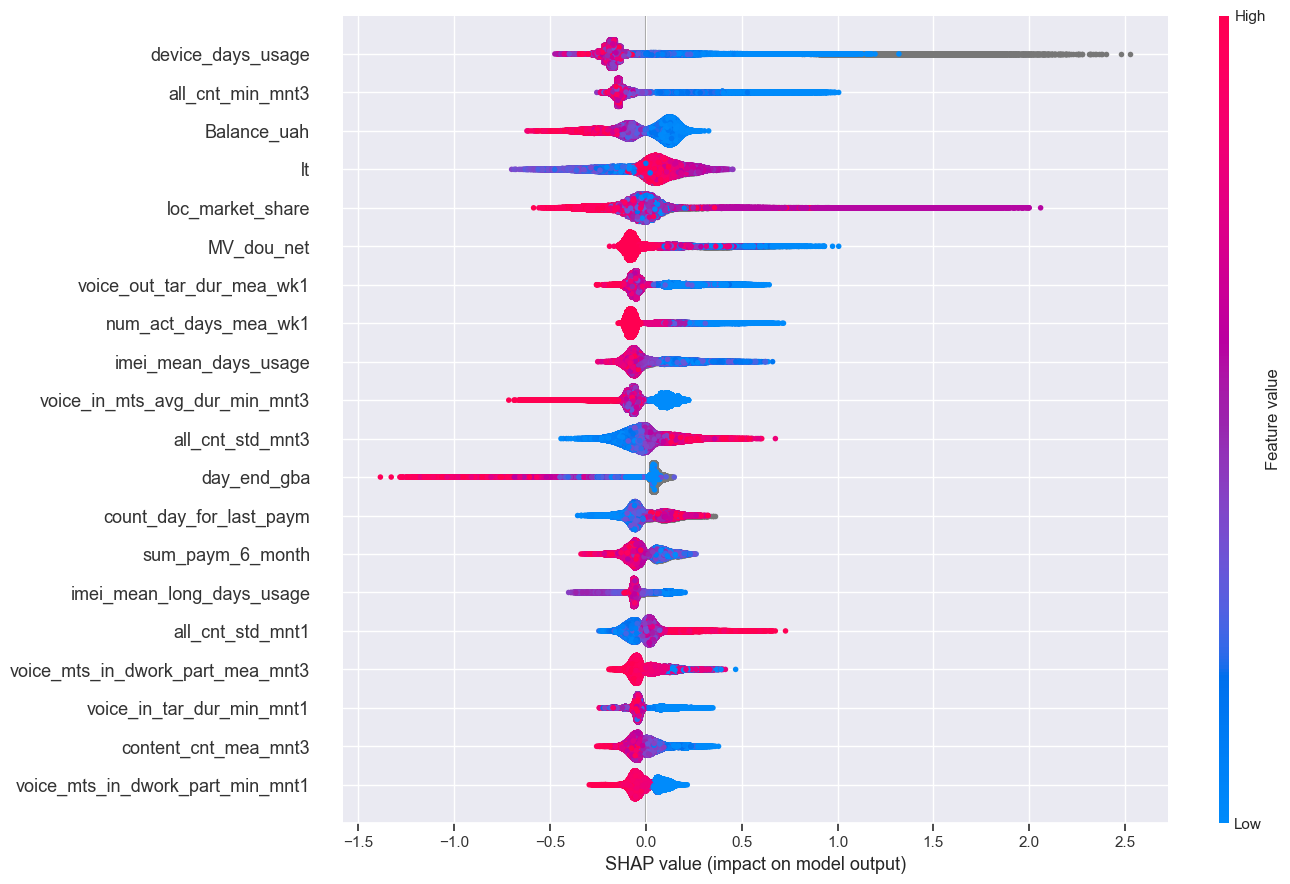

In [25]:
# shap
import shap
fea_lgb = model_test.feature_name_
explainer = shap.TreeExplainer(model_test)
shap_values = explainer.shap_values(X_test[fea_lgb])
pd.DataFrame(shap_values[1])
 
shap.summary_plot(shap_values[1], X_test[fea_lgb], plot_size=(14,9)) 

In [59]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

N = 20
# Load the model and features from the pickle file using your custom function
model_test, features = my_func.load_pickle('LGBMClassifier_01072023_17_07.pickle')

# Get the feature importances from the model
feature_importances = model_test.feature_importances_

# Sort the features based on their importance scores
sorted_features = sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True)

# Select the top N features to plot (change the value of N as needed)
top_features = [feat for feat, _ in sorted_features[:N]]

n_cols = 2  # Number of columns in the grid of plots
n_rows = math.ceil(len(top_features) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 5 * n_rows), constrained_layout=True)

# Make all the axes invisible initially
for ax in axes.flatten():
    ax.set_visible(False)

for idx, feature in enumerate(top_features):
    row, col_idx = divmod(idx, n_cols)
    ax = axes[row, col_idx]
    ax.set_visible(True)

    sns.boxplot(x=feature, y='target', data=df_train_fe, ax=ax)

    # Set the x-axis label as the feature name
    ax.set_xlabel(feature)

plt.show()
